In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import torch
import numpy as np
from PIL import Image
from glob import glob
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

/home/niedermayr/anaconda3/envs/punctum12/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from plyfile import PlyData
from pointnet.sh import to_spherical

plydata = PlyData.read("sphere.ply")
vertex_data = plydata["vertex"].data

def unpack_data(data, field_names):
    return torch.from_numpy(np.stack([data[key] for key in field_names]).T)

cameras = unpack_data(vertex_data, ["x", "y", "z"])

# avg_color = perceived_colors.mean(dim=0)
cameras_spherical = to_spherical(cameras)

print(f"loaded {cameras_spherical.shape[0]} cameras from sphere.ply")

loaded 162 cameras from sphere.ply


In [3]:


def get_img_id(path):
    return int(path.split(".")[0].split("_")[-1])

def load_img(path):
    img = Image.open(path)
    return torch.from_numpy(np.array(img)).float()/255

name = "1024max_256"
folder = f"renders/renders_{name}"


render_sh = {get_img_id(f):load_img(f) for f in glob(f"{folder}/render_sh_*.png")}

renders = glob(f"{folder}/render_sh_*.png")

mapping = {
    "sh":0,
    "no sh":1,
    "multi":2,
}

images = []
masks = []
for filename in renders:
    cam_id = get_img_id(filename)

    mask = load_img(f"{folder}/sh_mask_{cam_id}.png")
    mask = (mask[:,:,0]==1.) & (mask[:,:,1]==0.) & (mask[:,:,2]==0.)
    masks.append(mask)

    images.append(torch.stack([
        load_img(f"{folder}/render_sh_{cam_id}.png"),
        load_img(f"{folder}/render_no_sh_{cam_id}.png"),
        load_img(f"{folder}/multisampled_{cam_id}.png")
    ]))

assert len(images) == len(cameras_spherical) == len(masks)

images = torch.stack(images).cuda()
masks = torch.stack(masks).cuda()
print(f"loaded {images.shape[0]} renders with resolution {images.shape[2]}x{images.shape[3]} pixels")#

loaded 162 renders with resolution 256x256 pixels


In [4]:
def masked_reduce(values:torch.Tensor,mask:torch.BoolTensor,reduce="mean"):
    indices = mask.nonzero()[:,0]
    target = torch.zeros(indices.max()+1,device=values.device)
    return target.scatter_reduce(0,indices,values[mask],reduce=reduce)

/tmp/ipykernel_65917/2222541662.py:4: UserWarning: scatter_reduce() is in beta and the API may change at any time. (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352645774/work/aten/src/ATen/native/TensorAdvancedIndexing.cpp:1550.)
  return target.scatter_reduce(0,indices,values[mask],reduce=reduce)


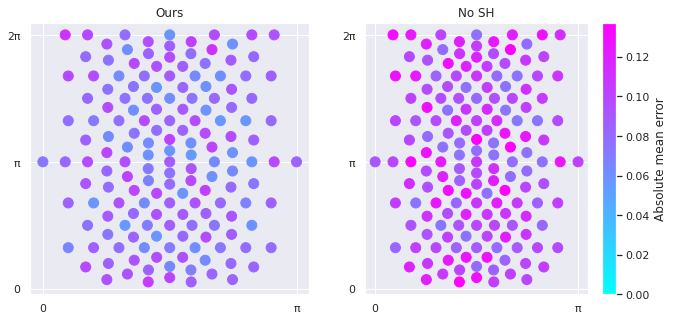

In [5]:
from math import pi
from matplotlib import cm,colors
cmap = cm.get_cmap('Spectral')

sh_error = (images[:,mapping["sh"]]-images[:,mapping["multi"]]).norm(1,dim=-1)/4
no_sh_error = (images[:,mapping["no sh"]]-images[:,mapping["multi"]]).norm(1,dim=-1)/4

sh_error_mean = masked_reduce(sh_error,masks,"mean")
no_sh_error_mean = masked_reduce(no_sh_error,masks,"mean")

vmax = max([sh_error_mean.max(),no_sh_error_mean.max()])

cmap = cm.cool

fig, [ax1,ax2] = plt.subplots(1,2,figsize=(11,5))

ax1.set_title("Ours")
ax1.set_yticks([0,pi,2*pi],["0","π","2π"])
ax1.set_xticks([0,pi],["0","π"])
#ax1.set_aspect('equal', adjustable='box')
pcm = ax1.scatter(cameras_spherical[:,0],cameras_spherical[:,1],s=100,c=sh_error_mean.cpu(),cmap=cmap,vmin=0,vmax=vmax)


ax2.set_title("No SH")
ax2.set_yticks([0,pi,2*pi],["0","π","2π"])
ax2.set_xticks([0,pi],["0","π"])
#ax2.set_aspect('equal', adjustable='box')
pcm = ax2.scatter(cameras_spherical[:,0],cameras_spherical[:,1],s=100,c=no_sh_error_mean.cpu(),cmap=cmap,vmin=0,vmax=vmax)
fig.colorbar(pcm, ax=ax2,orientation='vertical', label='Absolute mean error')


Text(0.5, 1.0, 'Mean absolute error')

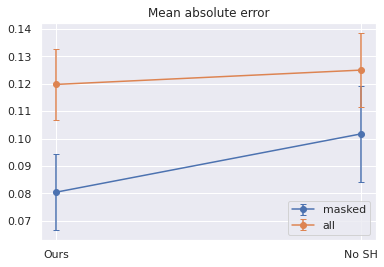

In [6]:
fig, ax = plt.subplots()

sh_all_mean = masked_reduce(sh_error, images[:, 0, :, :, 3] == 1)
no_sh_all_mean = masked_reduce(no_sh_error, images[:, 0, :, :, 3] == 1)

ax.errorbar(
    [0, 1],
    [sh_error_mean.mean().cpu(), no_sh_error_mean.mean().cpu()],
    [sh_error_mean.std().cpu(), no_sh_error_mean.std().cpu()],
    label="masked",
    fmt="-o",
    capsize=3
)
ax.errorbar(
    [0, 1],
    [sh_all_mean.mean().cpu(), no_sh_all_mean.mean().cpu()],
    [sh_all_mean.std().cpu(), no_sh_all_mean.std().cpu()],
    label="all",
    fmt="-o",
    capsize=3
)
ax.set_xticks([0,1],["Ours","No SH"])
ax.legend()
ax.set_title("Mean absolute error")


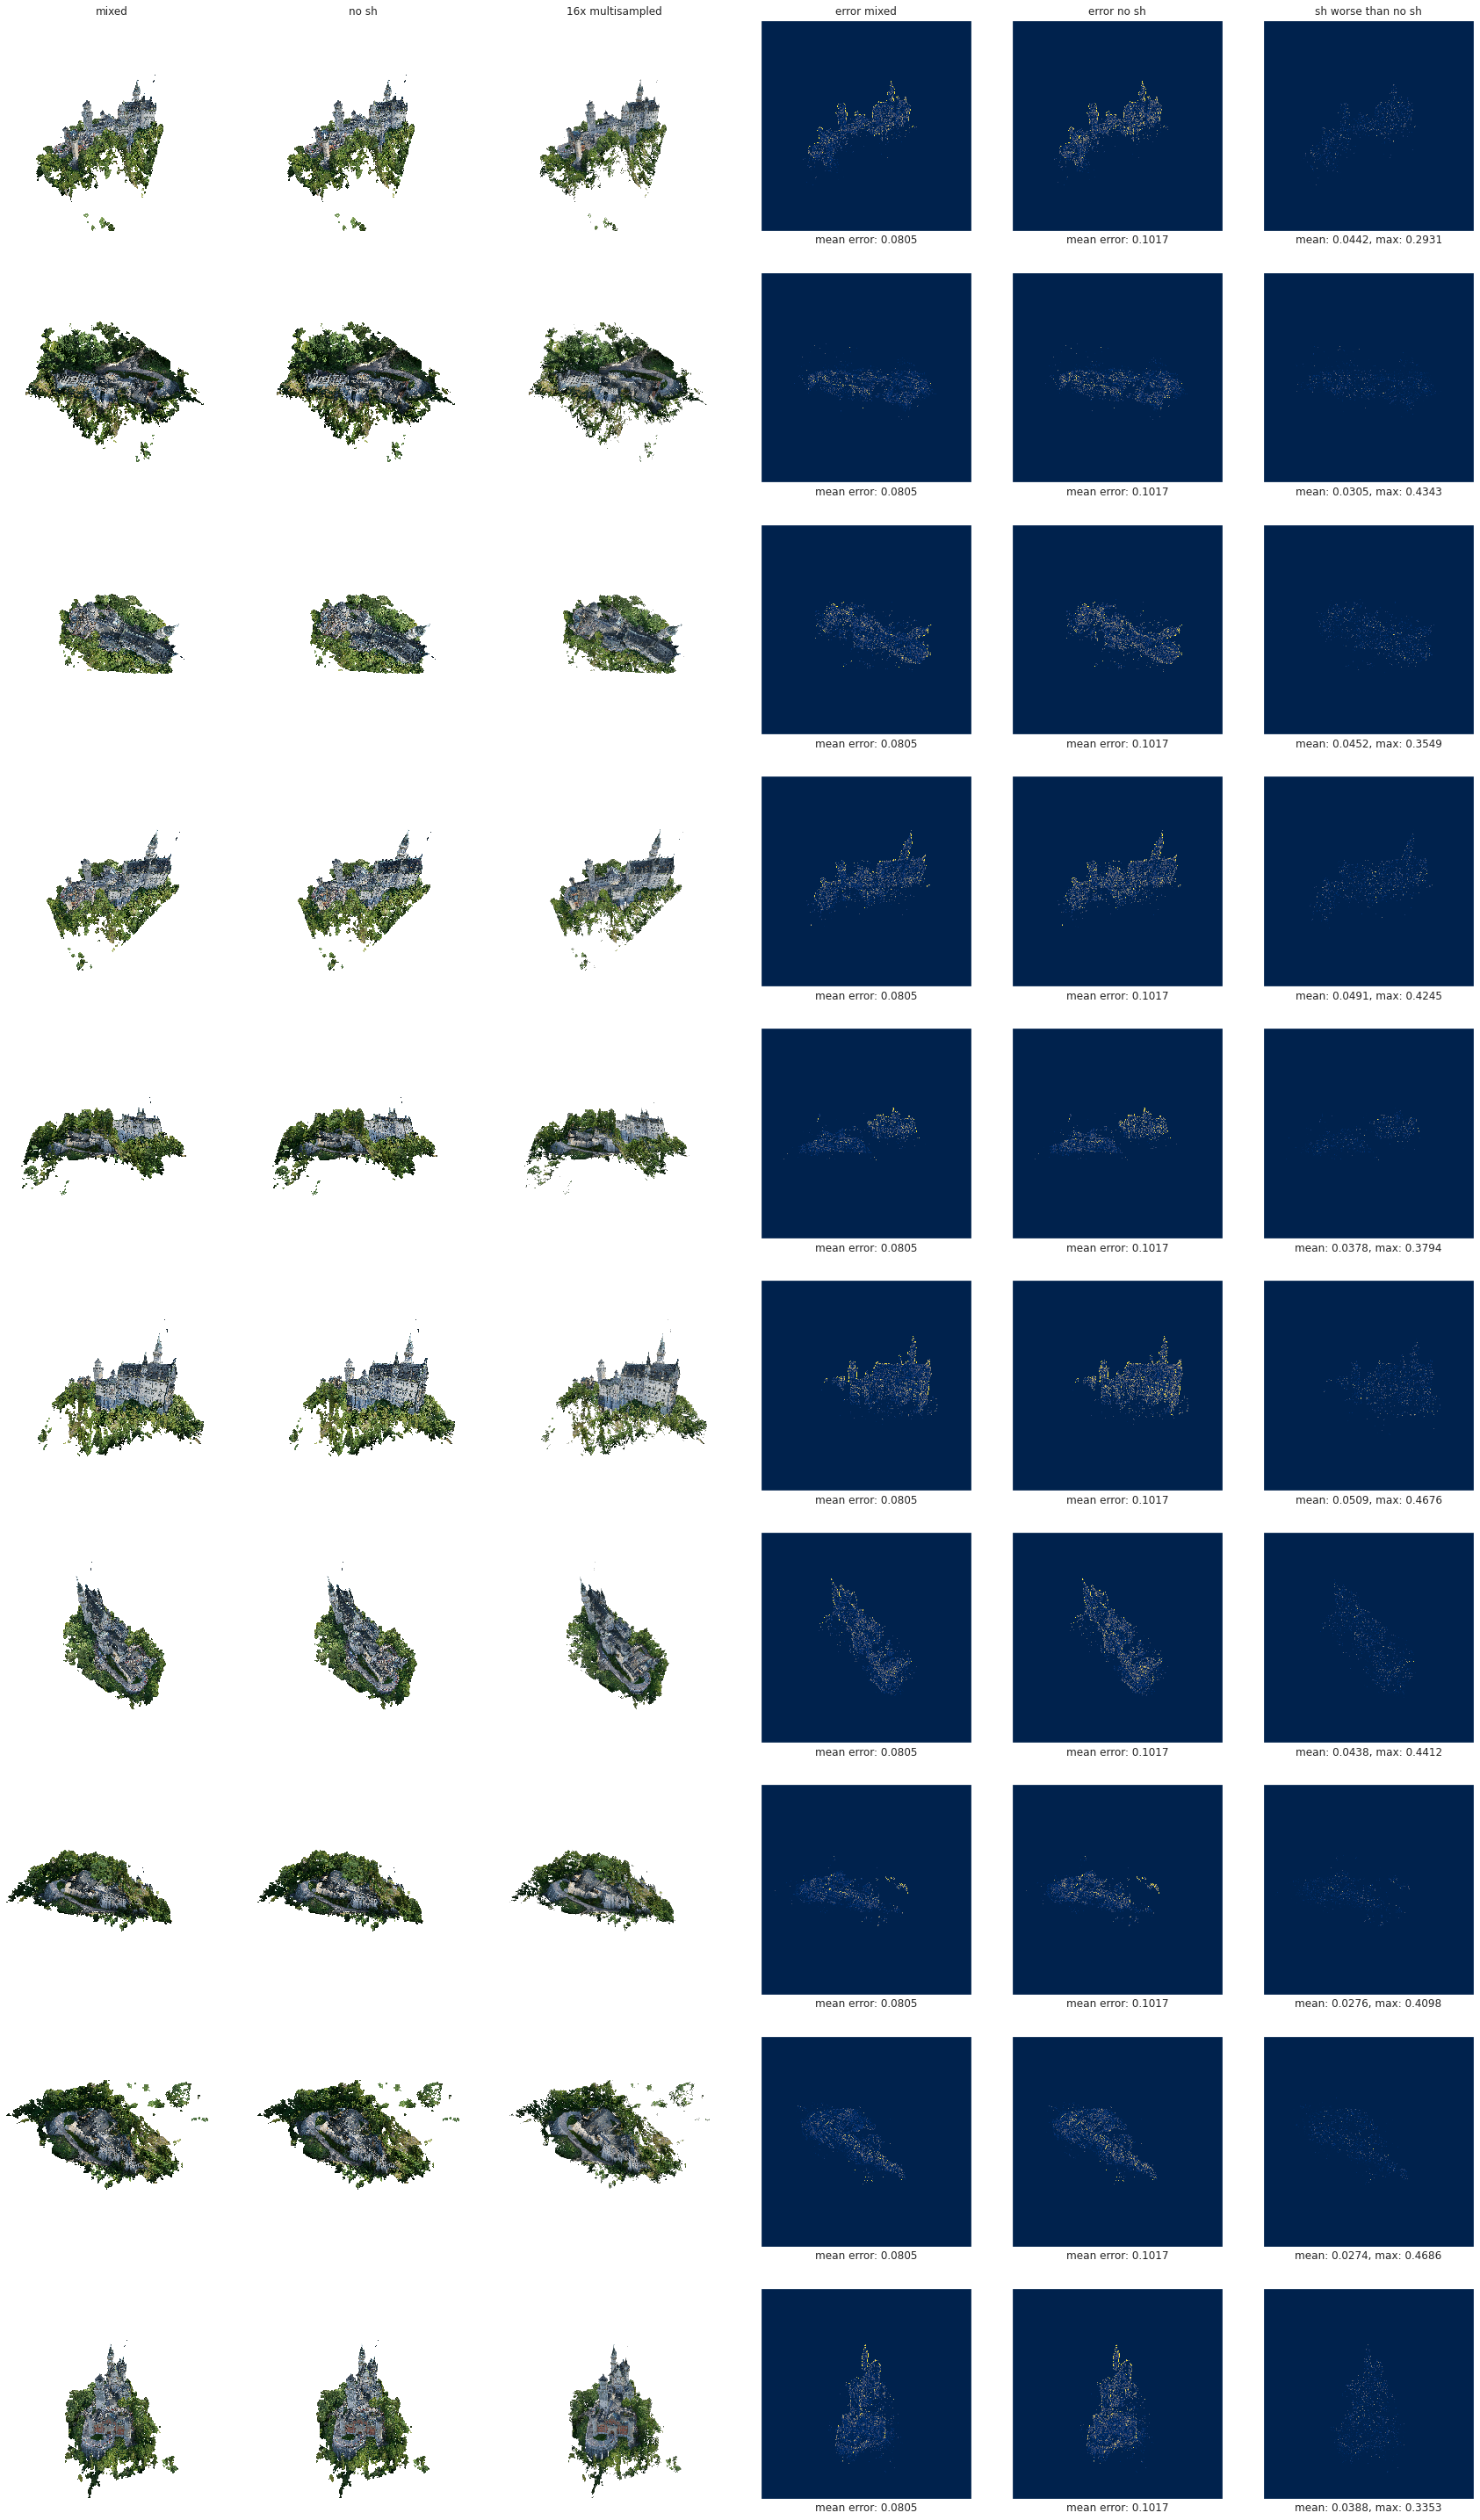

In [9]:

scale = 4
cols = 6
rows = 10
fig,axes = plt.subplots(rows,cols,figsize=(cols*scale,rows*scale))
plt.tight_layout()

errors = []
errors_masked = []

cmap = "cividis"

for i,idx in enumerate(torch.randint(len(render_sh),(rows,))):
    img_sh  = images[idx,mapping["sh"]]
    img_no_sh = images[idx,mapping["no sh"]]
    mask_img = masks[idx]
    multi = images[idx,mapping["multi"]]
    
    (ax1,ax2,ax3,ax4,ax5,ax6) = axes[i]

    if i==0:
        ax1.set_title("mixed")
        ax2.set_title("no sh")
        ax3.set_title("16x multisampled")
        ax4.set_title("error mixed")
        ax5.set_title("error no sh")
        ax6.set_title("sh worse than no sh")

    ax1.imshow(img_sh.cpu(),interpolation="nearest")
    ax1.axis("off")

    ax2.imshow(img_no_sh.cpu(),interpolation="nearest")
    ax2.axis("off")

    ax3.imshow(multi.cpu(),interpolation="nearest")
    ax3.axis("off")

    ax4.imshow((sh_error[idx]*mask_img.float()).cpu(),vmin=0,vmax=0.5,interpolation="nearest",cmap=cmap)
    ax4.axis("on")
    ax4.set_yticks([],[])
    ax4.set_xticks([],[])
    ax4.set_xlabel(f"mean error: {round(sh_error_mean.mean().item(),4)}")

    ax5.imshow((no_sh_error[idx]*mask_img.float()).cpu(),vmin=0,vmax=0.5,interpolation="nearest",cmap=cmap)
    ax5.axis("on")
    ax5.set_yticks([],[])
    ax5.set_xticks([],[])
    ax5.set_xlabel(f"mean error: {round(no_sh_error_mean.mean().item(),4)}")

    error_worse = sh_error[idx] - no_sh_error[idx]
    error_worse[error_worse<0]=0
    ax6.imshow(error_worse.cpu(),vmin=0,vmax=0.5,interpolation="nearest",cmap=cmap)
    ax6.axis("on")
    ax6.set_yticks([],[])
    ax6.set_xticks([],[])
    ax6.set_xlabel(f"mean: {round(error_worse[mask_img & (error_worse > 0)].mean().item(),4)}, max: {round(error_worse[mask].max().item(),4)}")

plt.savefig(f"evaluation/samples_{name}.png",dpi=300)